In [1]:
# import necessary libraries 
import pyarrow
import dask.dataframe as dd
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import seaborn as sns
import os
from tensorflow import keras
from sklearn.metrics import (accuracy_score, precision_score, recall_score, confusion_matrix, precision_recall_curve, ConfusionMatrixDisplay, classification_report, auc, roc_curve, precision_recall_fscore_support, f1_score)
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses, regularizers, models
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import RFECV
from sklearn.metrics import roc_auc_score, roc_curve
import pickle



In [2]:
tf.keras.utils.set_random_seed(42)

# Paths

In [3]:
processed_dir = os.path.join( "..", "data", "processed")
final_dataset_path = os.path.join(processed_dir, 'FEData_For_Modelling.parquet')
minority_users_nn_pq = os.path.join(processed_dir, 'minority_users_nn_smote.parquet')

models_dir = os.path.join( "..", "models","models")
model_dump_path = os.path.join(models_dir, 'nn_model_smote.pkl')

Import Dataset

In [4]:
# Read the multi-part Parquet dataset
fds = dd.read_parquet(final_dataset_path)
fds['malicious'] = fds['malicious'].astype(int)
fds.head(4000)

,user,O,C,E,A,N,FCwke,FCowh,FCwh,SDwke,SDowh,SDwh,CDwke,CDowh,CDwh,JDwke,JDowh,JDwh,malicious
0,AAB1302,38,41,10,38,28,23,37,142,0,1,10,0,0,0,40,81,246,0
1,AAB1762,32,39,18,18,33,0,194,654,0,9,14,0,0,4,0,243,679,0
2,AAC0904,31,30,36,18,28,0,0,0,0,22,144,0,5,34,0,499,4025,0
3,AAC1033,42,40,40,22,29,0,0,0,0,14,72,0,0,1,0,1,2,0
4,AAC1489,24,13,42,24,38,0,0,0,0,1,175,0,0,2,0,101,5058,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,ZRF1980,43,41,26,16,30,0,9,1272,0,16,298,0,0,11,0,28,494,0
1996,ZUR1449,31,42,12,36,17,0,0,0,0,1,7,0,65,296,0,293,1322,0
1997,ZVW1475,38,35,18,24,37,0,0,0,0,0,1,0,0,0,0,2,7,0
1998,ZWS0755,45,47,42,39,28,0,0,0,0,58,266,0,0,0,0,148,810,0


In [5]:
X = fds.drop(columns = ['malicious']).compute()
y = fds['malicious'].compute()

In [6]:
# Split the fds into training and testing sets
X_train_w_name, X_test_w_name, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_test = X_train_w_name.drop(columns=["user",]), X_test_w_name.drop(columns=["user",])

print("Train Labels before Resampling")
print(Counter(y_train))

Train Labels before Resampling
Counter({0: 1574, 1: 26})


## SMOTE

In [7]:
#transform the dataset
oversample = SMOTE(sampling_strategy=0.4, random_state=42) #sampling_strategy=0.8
X_train, y_train = oversample.fit_resample(X_train, y_train)

print("Train Labels after Resampling")
print(Counter(y_train))

Train Labels after Resampling
Counter({0: 1574, 1: 629})


In [8]:
# Standardize features, using minmax and not standardscale -> got dif??
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)
print(X_test.shape,X_train.shape)

(400, 17) (2203, 17)


# Hyperparameter Tuning

In [9]:
# Define X_train, y_train, X_test, y_test here
# Define the neural network architecture
def create_model(neurons_layer1=64, neurons_layer2=32, learning_rate=0.01):
    model = Sequential([
        Dense(neurons_layer1, activation='relu', input_shape=(17,)),
        Dense(neurons_layer2, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['recall'])
    return model

# Define parameter values to loop over
neurons_layer1_values = [32, 64, 128]
neurons_layer2_values = [16, 32, 64]
learning_rates = [0.001, 0.01, 0.1]

best_recall = 0
best_params = {}

# Iterate over parameter combinations
for neurons_layer1 in neurons_layer1_values:
    for neurons_layer2 in neurons_layer2_values:
        for learning_rate in learning_rates:
            # Create the model
            model = create_model(neurons_layer1=neurons_layer1, neurons_layer2=neurons_layer2, learning_rate=learning_rate)
            
            # Train the model
            history = model.fit(X_train, y_train, epochs=50, batch_size=64, validation_split=0.2, shuffle=True, verbose=0)
            
            # Evaluate the model
            loss, recall = model.evaluate(X_test, y_test)
            
            # Check if current accuracy is better than the best accuracy so far
            if recall > best_recall:
                best_recall = recall
                best_params = {'neurons_layer1': neurons_layer1, 'neurons_layer2': neurons_layer2, 'learning_rate': learning_rate}

# Print best parameters and corresponding accuracy
print("Best parameters found: ", best_params)
print("Best Recall: ", best_recall)

c:\Users\hydro\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0755 - recall: 0.0000e+00 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1803 - recall: 0.0000e+00 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 876us/step - loss: 0.1511 - recall: 0.0893   
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0762 - recall: 0.0000e+00 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1515 - recall: 0.5893         
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1588 - recall: 0.0893     
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step - loss: 0.0810 - recall: 0.0893   
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3135 - recall: 0.0000e+00 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1741 - recall: 0.0000e+00 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0607 - recall: 0.0000e+00 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2053 - recall: 0.0893     
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1925 - recall: 0.0000e+00 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0618 - recall: 0.0000e+00 
13/13 ━━

## Building the model

In [10]:
# Define the neural network architecture
model = Sequential([
    Dense(best_params['neurons_layer1'], activation='relu', input_shape=(17,)),
    Dense(best_params['neurons_layer2'], activation='relu'),
    Dense(1, activation='sigmoid')
])
optimizer = Adam(learning_rate = best_params['learning_rate'])
# Compile the model
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['recall'])


In [11]:
history = model.fit(X_train, y_train,
                    epochs = 150,
                    batch_size = 64,
                    validation_split = 0.2,
                    shuffle = True,
                    #callbacks = [early_stopping]
                    )

# Evaluate the model
loss, recall = model.evaluate(X_train, y_train)
print("Final Loss:", loss)
print("Final Recall:", recall)

Epoch 1/150


28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.4932 - recall: 0.0893 - val_loss: 1.7206 - val_recall: 0.0000e+00
Epoch 2/150
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3149 - recall: 0.0000e+00 - val_loss: 1.8331 - val_recall: 0.0000e+00
Epoch 3/150
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2859 - recall: 0.0000e+00 - val_loss: 1.7037 - val_recall: 0.0000e+00
Epoch 4/150
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2569 - recall: 0.0944 - val_loss: 1.2574 - val_recall: 0.0000e+00
Epoch 5/150
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1611 - recall: 0.4261 - val_loss: 0.9138 - val_recall: 0.4444
Epoch 6/150
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1374 - recall: 0.7216 - val_loss: 0.6218 - val_recall: 0.8435
Epoch 7/150
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1112 - recall: 0.8775 - val_loss: 0.3200 - val_recall: 0.9456
Epoch 8/150
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1132 - recall: 0.8604 - val_loss: 0.6859 - val_recall: 0.7846
Epoc

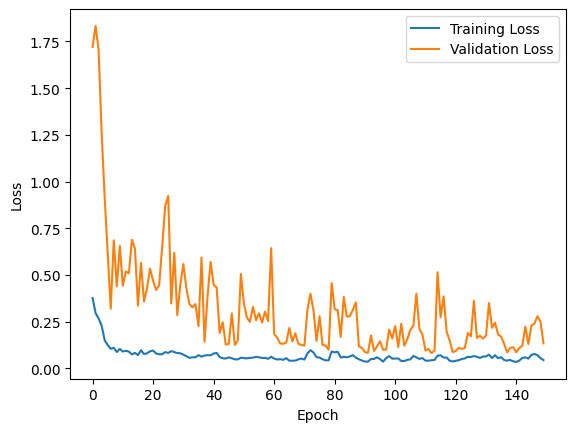

In [12]:
# loss plot
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

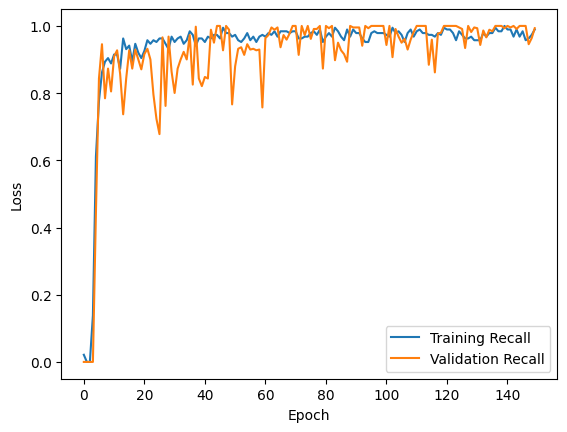

In [13]:
# acc plot
plt.plot(history.history["recall"], label="Training Recall")
plt.plot(history.history["val_recall"], label="Validation Recall")
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

Prediction

Threshold tuning

In [46]:
def calculate_tp_fp_fn(y_true, y_pred_prob, threshold):
    """
    Calculate True Positives (TP), False Positives (FP), and False Negatives (FN) 
    based on the given true labels (y_true) and predicted labels (y_pred) with a given threshold.
    
    Args:
    - y_true: True labels
    - y_pred: Predicted labels (probabilities or scores)
    - threshold: Threshold for classification
    
    Returns:
    - TP: Number of True Positives
    - FP: Number of False Positives
    - FN: Number of False Negatives
    """
    y_pred_binary = (y_pred_prob > threshold).astype(int)
    cm = confusion_matrix(y_true, y_pred_binary)
    TN, FP, FN, TP = cm.ravel()
    
    return TP, FP, FN

In [49]:
def threshold_tuning(y_test,y_pred_prob,tp_weight,fp_weight,fn_weight, threshold = 0.5):
    best_t_score = float('-inf')
    best_threshold = threshold
    while threshold >= 0: 
        Tp, Fp , Fn = calculate_tp_fp_fn(y_test, y_pred_prob, threshold)
        t_score = Tp*tp_weight - Fp*fp_weight - Fn*fn_weight
        threshold -= 0.01
        if t_score > best_t_score:
            best_t_score = t_score
            best_threshold = threshold
    return best_threshold

0.45999999999999996
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 794us/step
Accuracy = 98.25%
Precision = 0.2
Recall = 0.25
f-1 score = 0.22222222222222224

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99       396
           1       0.20      0.25      0.22         4

    accuracy                           0.98       400
   macro avg       0.60      0.62      0.61       400
weighted avg       0.98      0.98      0.98       400



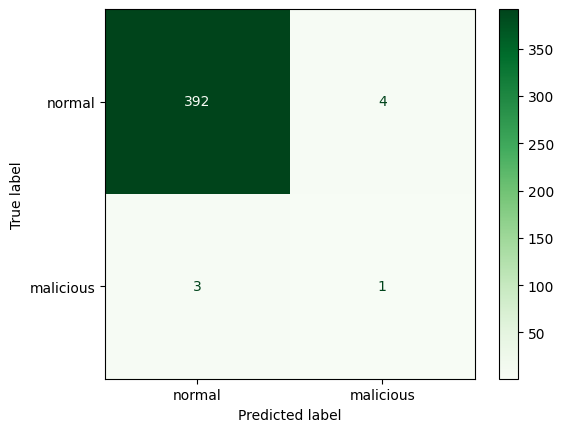

In [50]:
threshold = threshold_tuning(y_test,y_pred_prob,tp_weight= 2, fp_weight= 1,fn_weight=0.5,threshold = 0.5)
print(threshold)
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > threshold).astype(int)
set(list(y_pred.flatten()))


accuracy = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = ['normal', 'malicious'])

print("Accuracy = {:.2f}%".format(accuracy_score(y_test, y_pred)*100))
print("Precision = {}".format(precision_score(y_test, y_pred)))
print("Recall = {}".format(recall_score(y_test, y_pred)))
print("f-1 score = {}".format(f1_score(y_test, y_pred)))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
disp.plot(cmap=plt.cm.Greens)
plt.show()

AUC score: 0.494949494949495


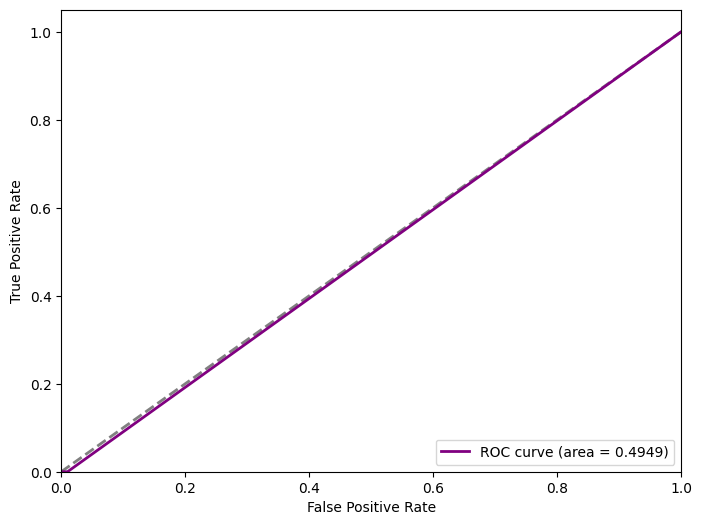

In [15]:
# ROC - AUC
def plot_roc_curve(true_y, y_prob):
    """
    plots the roc curve based of the probabilities
    """
    plt.figure(figsize=(8, 6))
    #y_prob = best_dt.predict_proba(X_test_scaled)[::,1]
    dt_fpr, dt_tpr, thresholds = roc_curve(true_y, y_prob)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    roc_auc = auc(dt_fpr, dt_tpr)
    plt.plot(dt_fpr, dt_tpr, color='purple', lw=2, label='ROC curve (area = %0.4f)' % roc_auc)
    plt.legend(loc="lower right")

    # plt.legend()

plot_roc_curve(y_test, y_pred)
print(f'AUC score: {roc_auc_score(y_test, y_pred)}')

### Risk scores

In [51]:
def custom_min_max_scale(arr):
    # Identify positive and negative values
    positive_values = arr[arr > 0]
    negative_values = arr[arr < 0]

    # Scale positive values to [0, 1]
    positive_scaled = positive_values / np.max(positive_values)

    # Scale negative values to [-1, 0]
    negative_scaled = negative_values / np.min(negative_values)

    # Replace original array with scaled values
    arr[arr > 0] = positive_scaled
    arr[arr < 0] = negative_scaled

    return abs(arr)

In [52]:
def get_risk_score(X,threshold):    
    prob = model.predict(X)
    data_array = threshold - prob
    confidence = abs(custom_min_max_scale(data_array))

    return confidence

In [53]:
train_risk = get_risk_score(X_train,threshold)
test_risk = get_risk_score(X_test,threshold)

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 817us/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 814us/step


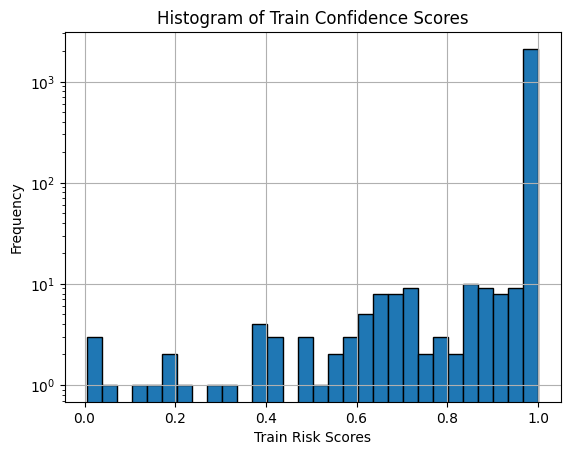

In [54]:
# Plot histogram for train risk score
plt.yscale('log')
plt.hist(train_risk, bins=30, edgecolor='black')  # Adjust bins as needed
plt.xlabel('Train Risk Scores')
plt.ylabel('Frequency')
plt.title('Histogram of Train Confidence Scores')
plt.grid(True)
plt.show()

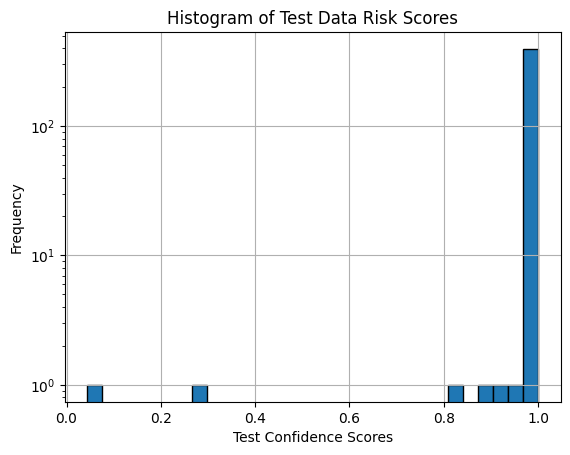

In [55]:
# Plot histogram for test risk score
plt.yscale('log')
plt.hist(test_risk, bins=30, edgecolor='black')  # Adjust bins as needed
plt.xlabel('Test Confidence Scores')
plt.ylabel('Frequency')
plt.title('Histogram of Test Data Risk Scores')
plt.grid(True)
plt.show()


In [56]:
print("Example Train Risk Scores:")
print(train_risk[:10])  
print("\nExample Test Risk Scores:")
print(test_risk[:10])

Example Train Risk Scores:
[[1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]]

Example Test Risk Scores:
[[1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]]


# Export Model

In [57]:
pickle.dump(model.weights, open(model_dump_path,'wb'))

#  Our Prediction and the Confidence Associated with it

## Helper Functions

In [58]:
def df_toparquet(pdf,path):
    ddf = dd.from_pandas(pdf)
    # Export the DataFrame to a parquet file=
    ddf.to_parquet(path, engine='pyarrow')


In [59]:
def get_minority_tables(y_pred_value, y_test_value,df):
    # Get rows of minority data
    minority_data = df[(df['Actual'] == y_test_value) & (df['Prediction'] == y_pred_value)]
    display(minority_data)

Creating Table for export

In [60]:
names_array = list(X_test_w_name['user'])
final_guess = {'User': names_array, 'Actual': list(y_test.astype(bool)), 'Prediction': list(y_pred.flatten().astype(bool)), 'Confidence of Prediction': list(test_risk.flatten())}
refactored_df = pd.DataFrame(final_guess)
df_toparquet(refactored_df,minority_users_nn_pq)
refactored_df


,User,Actual,Prediction,Confidence of Prediction
0,VAH1292,False,False,1.0
1,CJL0143,False,False,1.0
2,MMB1967,False,False,1.0
3,IVS1411,False,False,1.0
4,MEB1743,False,True,1.0
...,...,...,...,...
395,JIG1593,False,False,1.0
396,MDL0294,False,False,1.0
397,SSG0726,False,False,1.0
398,BWJ1539,False,False,1.0


In [61]:
print("False Positives")
get_minority_tables(1, 0,refactored_df)

print("False Negatives")
get_minority_tables(0, 1,refactored_df)

print("True Positives")
get_minority_tables(1,1,refactored_df)

False Positives


,User,Actual,Prediction,Confidence of Prediction
4,MEB1743,False,True,1.0
158,EKS1182,False,True,1.0
355,ERM1590,False,True,1.0
363,BDF0015,False,True,1.0


False Negatives


,User,Actual,Prediction,Confidence of Prediction
224,TNB1616,True,False,1.000000
290,MCP0611,True,False,0.926079
318,TMT0851,True,False,1.000000


True Positives


,User,Actual,Prediction,Confidence of Prediction
60,OKM1092,True,True,0.043612
